In [ ]:

!git clone https://bitbucket.org/jadslim/german-traffic-signs

!ls german-traffic-sign

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2
  
  
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
  
%matplotlib inline

np.random.seed(0)


Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), 117.80 MiB | 12.54 MiB/s, done.
ls: cannot access 'german-traffic-sign': No such file or directory


In [ ]:
# TODO: Implement load the data here.
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
# TODO: Load test data

with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

In [ ]:
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
  
#already 4 dimensional
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [ ]:

# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

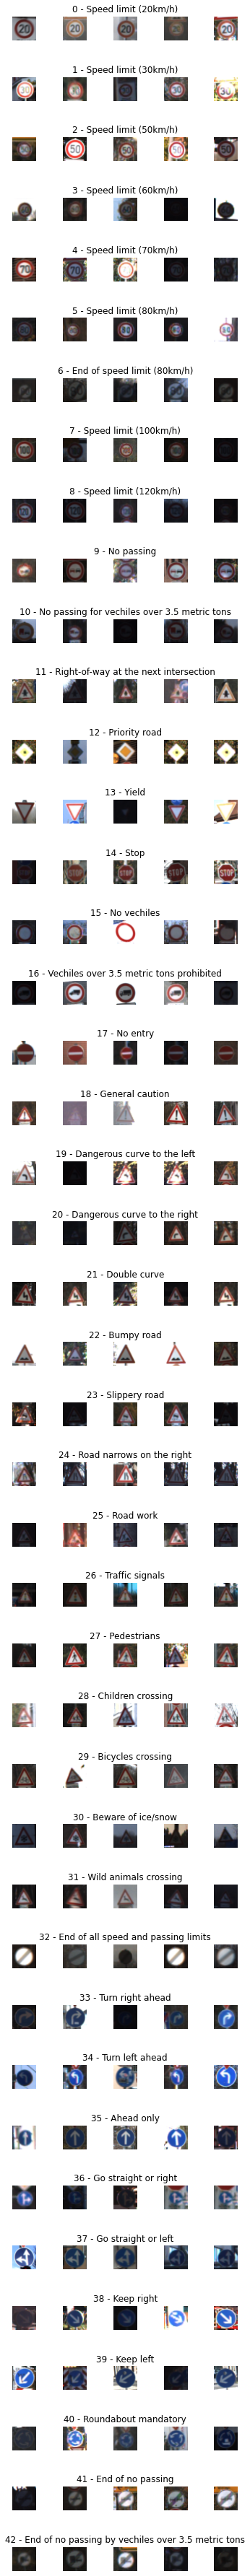

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
  
num_of_samples=[]
  
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


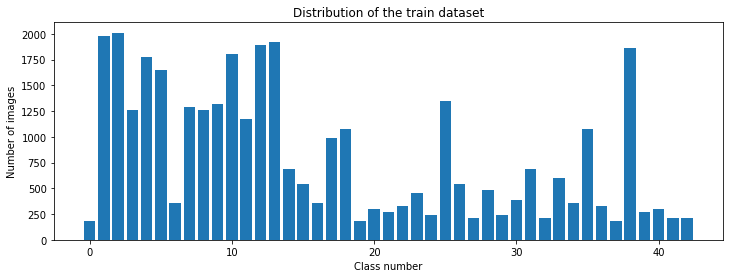

In [ ]:

print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()


(32, 32, 3)
36
(32, 32)
(32, 32)


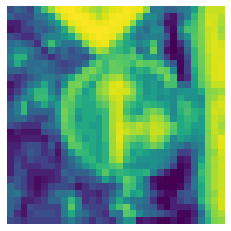

In [ ]:
import cv2
  
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

(34799, 32, 32)


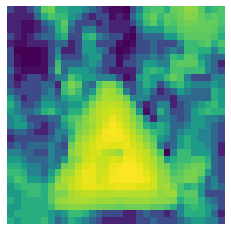

In [ ]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
  
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
  
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
  
datagen.fit(X_train)

(15, 32, 32, 1)


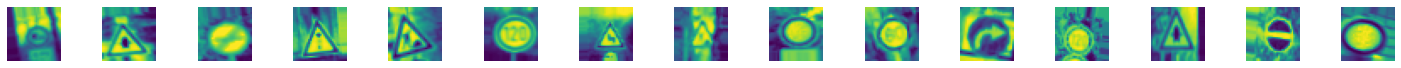

In [ ]:
# for X_batch, y_batch in
  

batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
  
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
  
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
  
print(X_batch.shape)

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [ ]:
# create model
  
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 60)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          16230     
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 30)          8130      
                                                        

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=len(X_train)/50,
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/10
695/695 [==============================] - 15s 22ms/step - loss: 0.2123 - accuracy: 0.9364 - val_loss: 0.0870 - val_accuracy: 0.9748
Epoch 2/10
695/695 [==============================] - 16s 23ms/step - loss: 0.1902 - accuracy: 0.9419 - val_loss: 0.0732 - val_accuracy: 0.9773
Epoch 3/10
695/695 [==============================] - 18s 27ms/step - loss: 0.1780 - accuracy: 0.9475 - val_loss: 0.0627 - val_accuracy: 0.9796
Epoch 4/10
695/695 [==============================] - 17s 25ms/step - loss: 0.1555 - accuracy: 0.9542 - val_loss: 0.0795 - val_accuracy: 0.9800
Epoch 5/10
695/695 [==============================] - 16s 23ms/step - loss: 0.1372 - accuracy: 0.9600 - val_loss: 0.0771 - val_accuracy: 0.9814
Epoch 6/10
695/695 [==============================] - 17s 24ms/step - loss: 0.1278 - accuracy: 0.9624 - val_loss: 0.1227 - val_accuracy: 0.9723
Epoch 7/10
695/695 [==============================] - 18s 25ms/step - loss: 0.1231 - accuracy: 0.9651 - val_loss: 0.0611 - val_accuracy:

Text(0.5, 0, 'epoch')

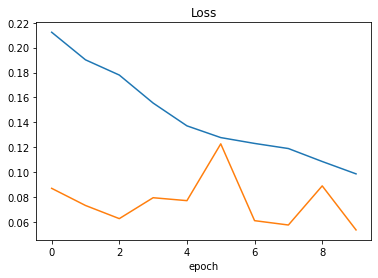

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

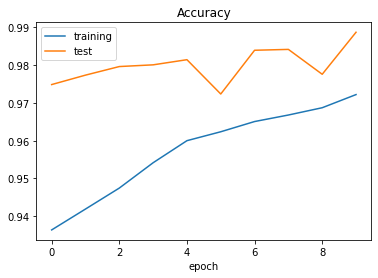

In [ ]:
  
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
# TODO: Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.172422856092453
Test accuracy: 0.9619952440261841


In [ ]:
#predict internet number
import requests
from PIL import Image
#url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
#url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
#url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
# url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
  
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
  
prediction = np.argmax(model.predict(img), axis=-1)

print("predicted sign: "+ str(prediction))

NameError: ignored

In [ ]:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# y_train = np_utils.to_categorical(y_train, num_classes)
# y_test = np_utils.to_categorical(y_test, num_classes)
# datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, rotation_range=20, 
#                              width_shift_range=0.2,height_shift_range=0.2,
#                              horizontal_flip=True)
# # compute quantities required for featurewise normalization
# # (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(x_train)
# # fits the model on batches with real-time data augmentation:
# model.fit(datagen.flow(x_train, y_train, batch_size=32),
#           steps_per_epoch=len(x_train) / 32, epochs=100)